# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


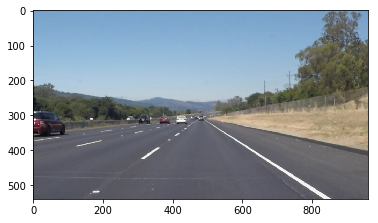

In [31]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [28]:
import math
import sys

############################################# EXPERIMENTAL ###########################
def extract_color(img, r, g, b):
    """ From https://stackoverflow.com/questions/43305234/opencv-python-confused-when-using-hsv-color-in-cv2-inrange
    """
    # first convert the img to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # convert the target color to HSV
    target_color = np.uint8([[[b, g, r]]])
    target_color_hsv = cv2.cvtColor(target_color, cv2.COLOR_BGR2HSV)

    # boundaries for Hue define the proper color boundaries, saturation and values can vary a lot
    target_color_h = target_color_hsv[0,0,0]
    tolerance = 2
    lower_hsv = np.array([max(0, target_color_h - tolerance), 10, 10])
    upper_hsv = np.array([min(179, target_color_h + tolerance), 250, 250])
    # Threshold the HSV image to get only yellow->white colors
    mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)

    # Bitwise-AND mask and original image
    return cv2.bitwise_and(img, img, mask= mask)

def extract_white(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # boundaries for Hue define the proper color boundaries, saturation and values can vary a lot
    tolerance = 5
    lower_hsv = np.array([0, 0, 0])
    upper_hsv = np.array([255, 35, 255])
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)

    # Bitwise-AND mask and original image
    return cv2.bitwise_and(img, img, mask= mask)

def extract_by_hue(img, hue):

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # boundaries for Hue define the proper color boundaries, saturation and values can vary a lot
    tolerance = 5
    lower_hsv = np.array([max(0, hue - tolerance), 10, 10])
    upper_hsv = np.array([min(250, hue + tolerance), 250, 250])

    mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)

    # Bitwise-AND mask and original image
    return cv2.bitwise_and(img, img, mask= mask)
    
def yellow_to_white(img):
    """Extracts yellow from the image then applies the Grayscale transform. """
    # Convert BGR to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # boundaries for Hue define the proper color boundaries, saturation and values can vary a lot
    tolerance = 5
    hue = 96
    lower_hsv = np.array([max(0, hue - tolerance), 10, 10])
    upper_hsv = np.array([min(250, hue + tolerance), 250, 250])

    mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)
    new_img = np.array(img)
    new_img[mask == 255] = [250, 250, 250]
   
    return new_img

def yellow_then_gray(img) :
    yellow, not_yellow = yellow_and_not_yellow(img)
    return cv2.cvtColor(yellow, cv2.COLOR_RGB2GRAY)

#######################################################################
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    img = yellow_to_white(img)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_info(line) :
    for x1,y1,x2,y2 in line:
        slope = (y2-y1)/(x2-x1)
        length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        b = y1 - (slope * x1)
        return length, slope, b

def line_from_slope(slope, b, y1, y2) :
    """
    Returns a line with slope and b(y intercept) from y1 to y2
    """
    # y= mx + b  , b = y-mx, x = (y-b)/m
    x1 = int(round((y1 - b) / slope, 0))
    x2 = int(round((y2 - b) / slope, 0))
    return [(x1, y1, x2, y2)]

def draw_fitted_line(img, x, y, min_y, max_y, color, thickness):
    """
    Draw a line fitted to a series of points detected by the hough transform.
    """
    if len(x) == 0 : return
    poly = np.polyfit(y, x, 1)
    f = np.poly1d(poly)
    y_new = np.linspace(min_y, max_y)
    x_new = f(y_new)
    curve_points = np.column_stack((x_new, y_new))
    curve_points = np.int32(curve_points)
    cv2.polylines(img, [curve_points], False, color, thickness)

def draw_lines_raw(shape, lines, color=[255, 0, 0], thickness=2):
    """
    Draw lines with no 
    """
    img = np.zeros(shape, dtype=np.uint8)
    for line in lines:
        length, slope, b = line_info(line)
        if ((slope > 0.1 and slope < 0.9) or (slope < -0.1 and slope > -0.9)) :
            for x1,y1,x2,y2 in line :
                cv2.line(img, (x1,y1), (x2, y2), color, thickness)
    return img 

def is_right_slope(slope):
    """
    Returns True if slope indicates this a lane on the right.
    """
    if (slope > 0.3 and slope < 0.8) : return True
    return False

def is_left_slope(slope):
    """
    Returns True if slope indicates this a lane on the left.
    """
    if (slope < -0.3 and slope > -0.8) : return True
    return False

def is_left(middle_x, line) :
    """
    Returns true if the line is on the left of the image and a slope that fits a left hand lane.
    `middle_x` center of image
    `line` line to test
    """
    length, slope, b = line_info(line)
    if (not is_left_slope(slope)) : return False 
    for x1,y1,x2,y2 in line:
        if x1 > middle_x or x2 > middle_x : return False
    return True

def is_right(middle_x, line) :
    """
    Returns true if the line is on the right of the image and a slope that fits a right hand lane.
    `middle_x` center of image
    `line` line to test
    """
    length, slope, b = line_info(line)
    if (not is_right_slope(slope)) : return False 
    for x1,y1,x2,y2 in line:
        if x1 < middle_x or x2 < middle_x : return False
    return True

def draw_lines_averaged(shape, lines, min_y, max_y,  color=[255, 0, 0], thickness=5):

    """
    Returns a new image of size `shape` with the lines drawn using a weighted average of slope and y-intercerpt. 
    Extrapolates the lines from `min_y` to `max_y` to correspond to the region of interest.
    Use `color` and `thickness` if supplied. 
    """
    img = np.zeros(shape, dtype=np.uint8)
    middle_x = shape[1] / 2
    
    left_length = 0.;
    left_slope = 0.;
    left_b = 0.;

    right_length = 0.;
    right_slope = 0.;
    right_b = 0.;
        
    for line in lines:
        length, slope, b = line_info(line) 
        for x1,y1,x2,y2 in line:
            #positive is left lane line
            if (is_right(middle_x, line)) :
                right_slope += slope * length
                right_b += b * length
                right_length += length
            elif (is_left(middle_x, line)) :
                left_slope += slope * length
                left_b += b * length
                left_length += length
                
    # Calculate the weighted average for the slope and y-intercept
    # Extrapolate a line from top to bottom of our region of interest.  
    if (left_length > 0):
        left_slope /= left_length
        left_b /= left_length
        left_line = line_from_slope(left_slope, left_b, min_y, max_y)
        for x1,y1,x2,y2 in left_line :
            cv2.line(img, (x1,y1), (x2, y2), color, thickness)
    
    if (right_length > 0):
        right_slope /= right_length
        right_b /= right_length
        right_line = line_from_slope(right_slope, right_b, min_y, max_y)
        for x1,y1,x2,y2 in right_line :
            cv2.line(img, (x1,y1), (x2, y2), color, thickness)
    return img

def add_points_from_line(line, x_points, y_points):
    length, slope, b = line_info(line)
    for x1,y1,x2,y2 in line:
        for x in range(x1, x2) :
            y = slope * x + b
            x_points.append(x)
            y_points.append(y)
    
def draw_lines_interpolated(shape, lines,  min_y, max_y, lcolor=[255, 0, 0], rcolor=[0, 255, 0], thickness=5):
    """
    Draw lanes lines on the left and right using a linear regression fitting from the set of lines detected from 
    the Hough transformation.
    `shape` is the size of the image to create.
    `lines` are the list of lines from HoutgLinesP
    `min_y` extrapolate the line from min_y - from region of interest 
    `max_y` extrapolate the line to max_y - from region of interest
    """
    middle_x = shape[1] / 2

    img = np.zeros(shape, dtype=np.uint8)
    right_x = []
    right_y = []
    left_x = []
    left_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (is_right(middle_x, line)) :
                add_points_from_line(line, right_x, right_y)

            elif (is_left(middle_x, line)) :
                add_points_from_line(line, left_x, left_y)
                
    draw_fitted_line(img, right_x, right_y, min_y, max_y, lcolor, thickness)
    draw_fitted_line(img, left_x, left_y, min_y, max_y, rcolor, thickness)
    return img
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, min_y, max_y):
    """
    `img` should be the output of a Canny transform.
        
    Returns the hough lines from the image
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [30]:
import os
test_images = os.listdir("test_images/")
print(test_images)



['subset', 'solidWhiteCurve.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteRight.jpg', 'curve1.jpg', '.ipynb_checkpoints', 'solidYellowCurve.jpg', 'curve2.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

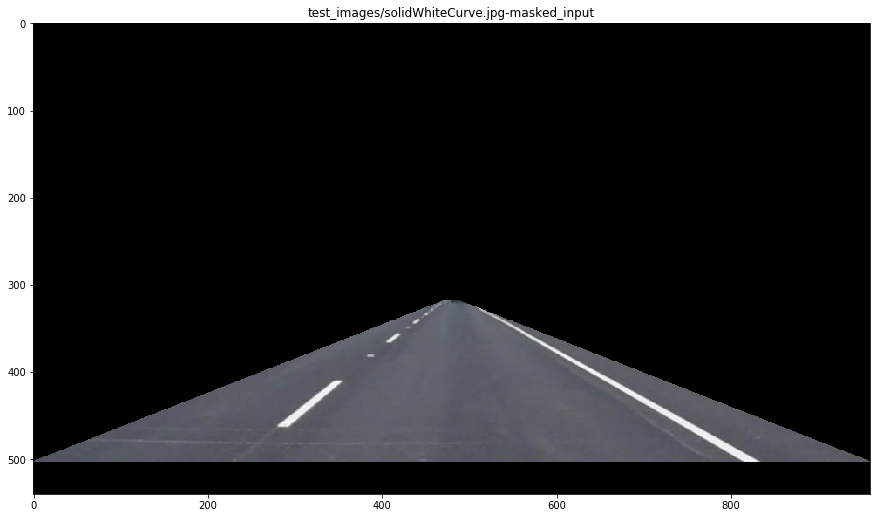

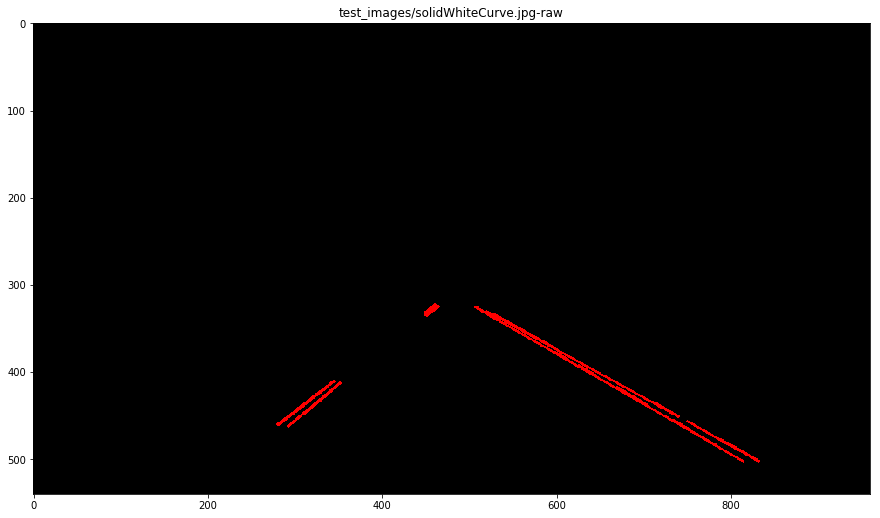

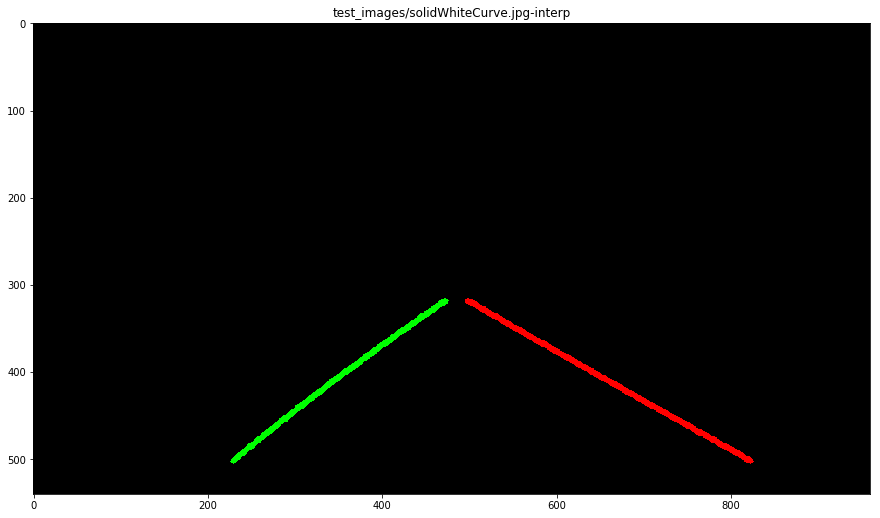

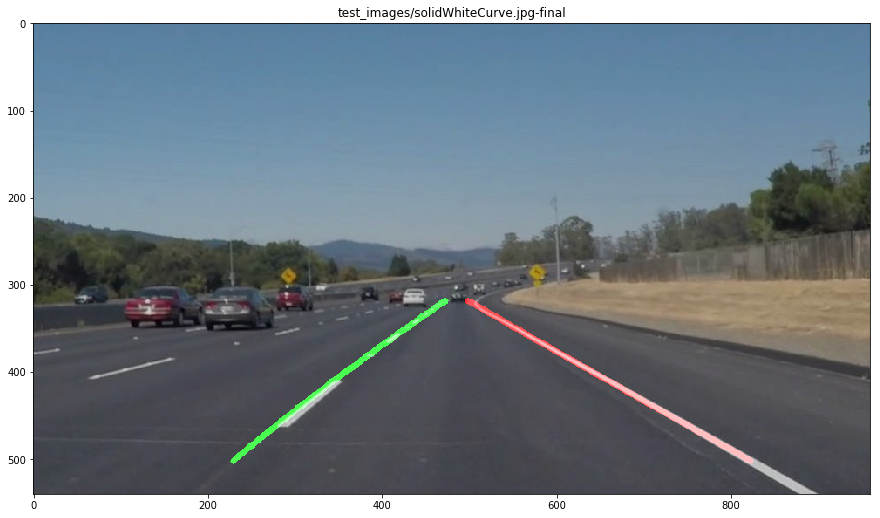

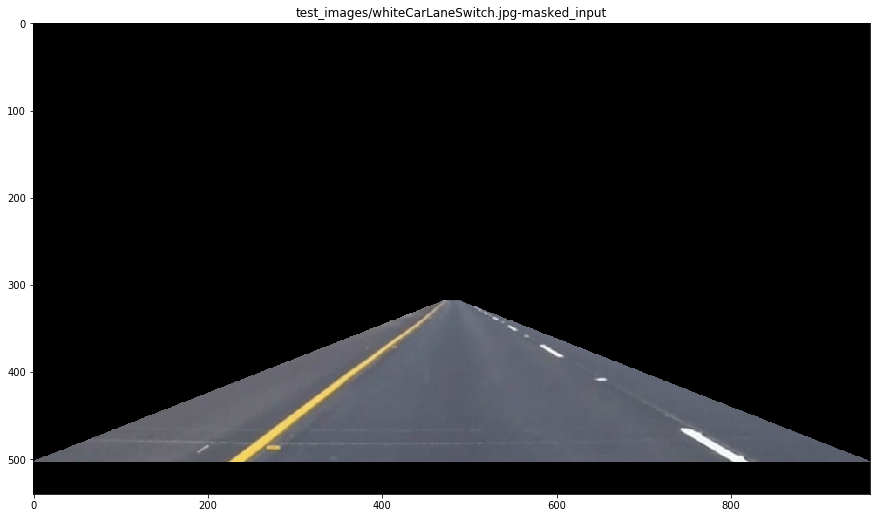

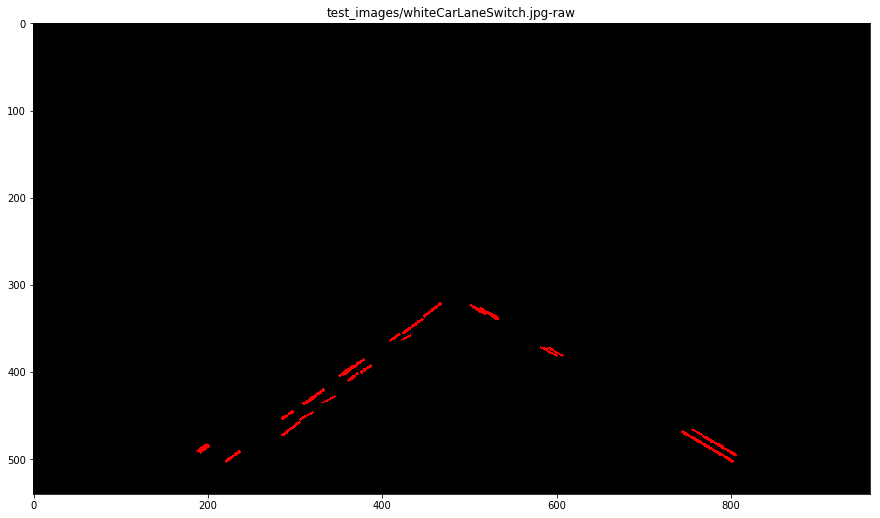

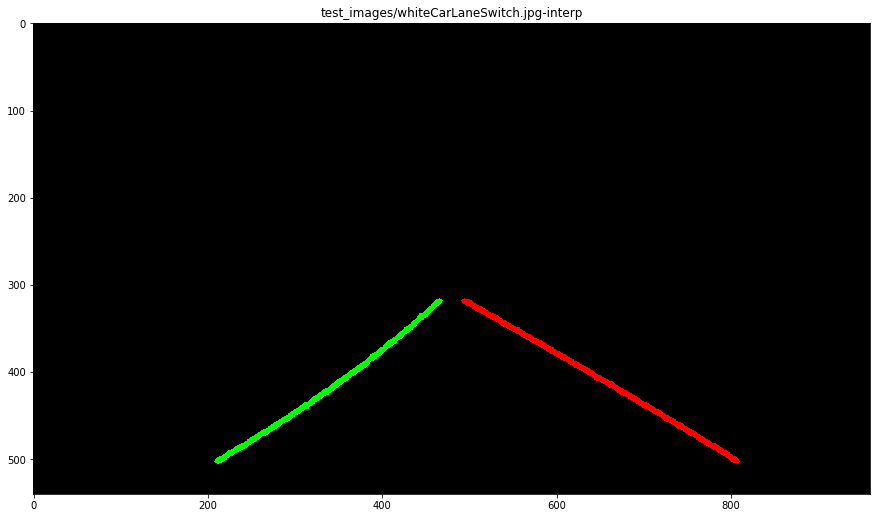

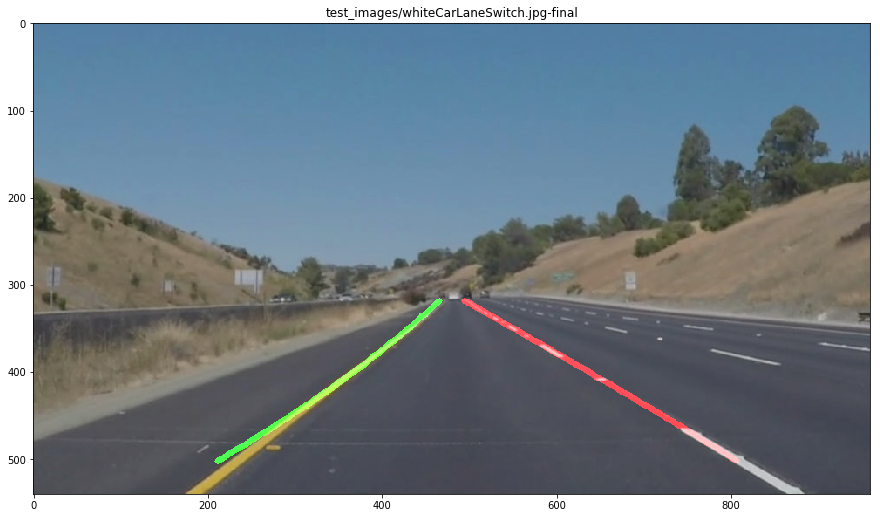

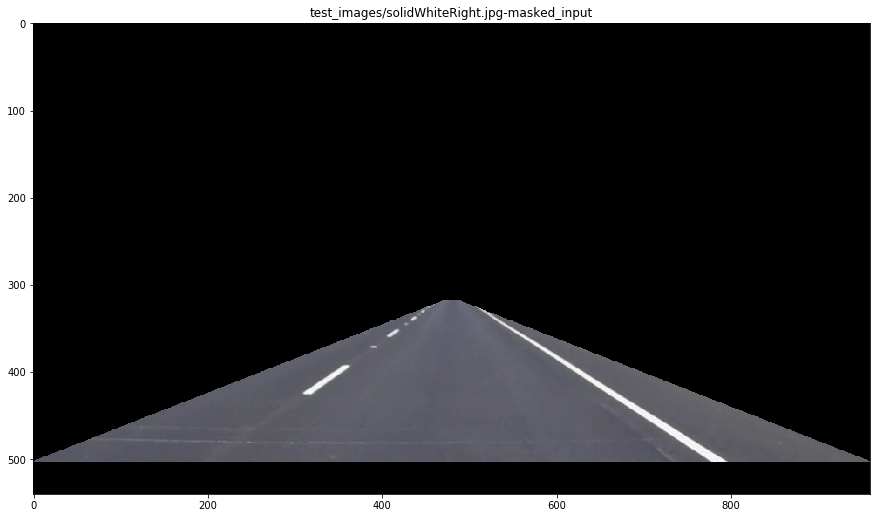

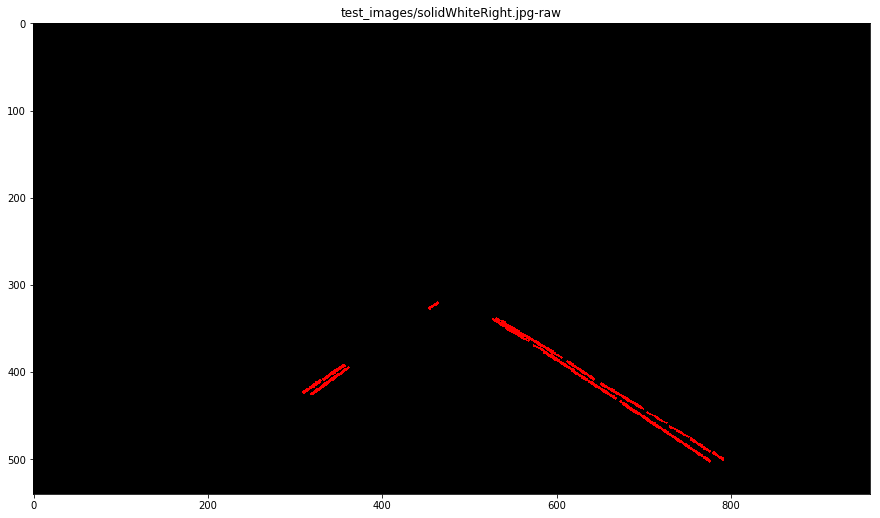

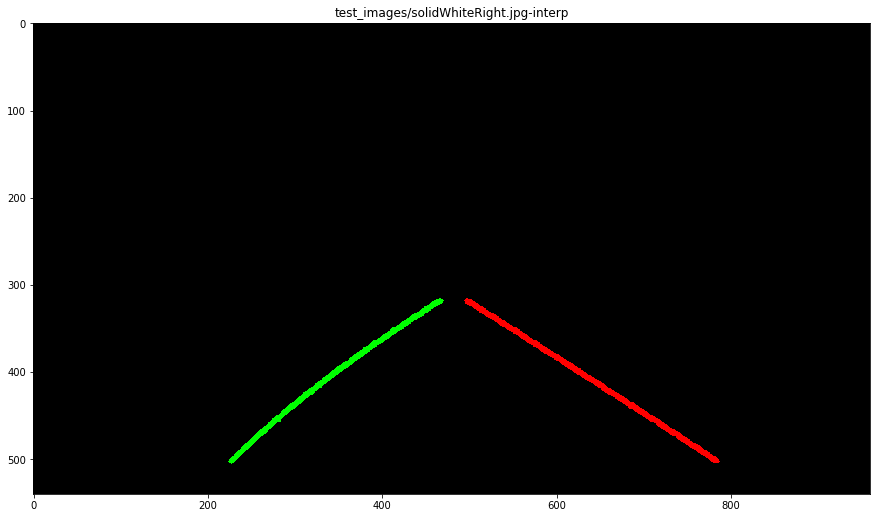

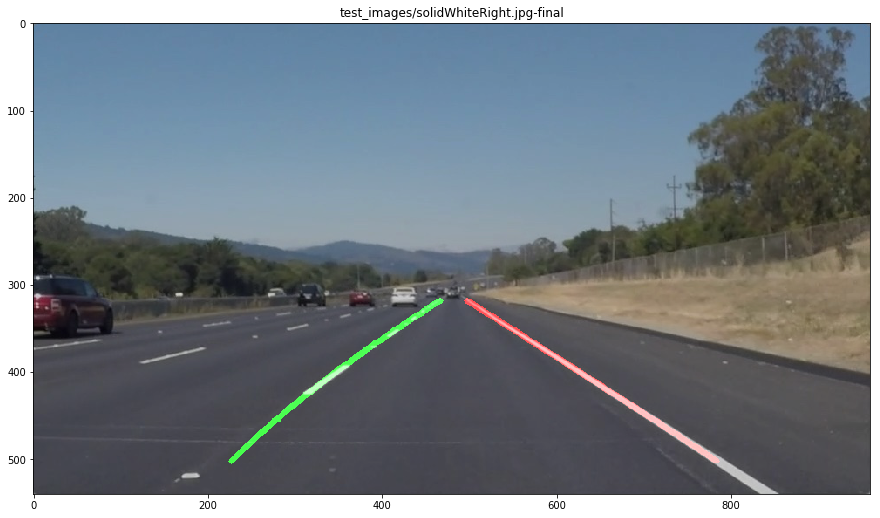

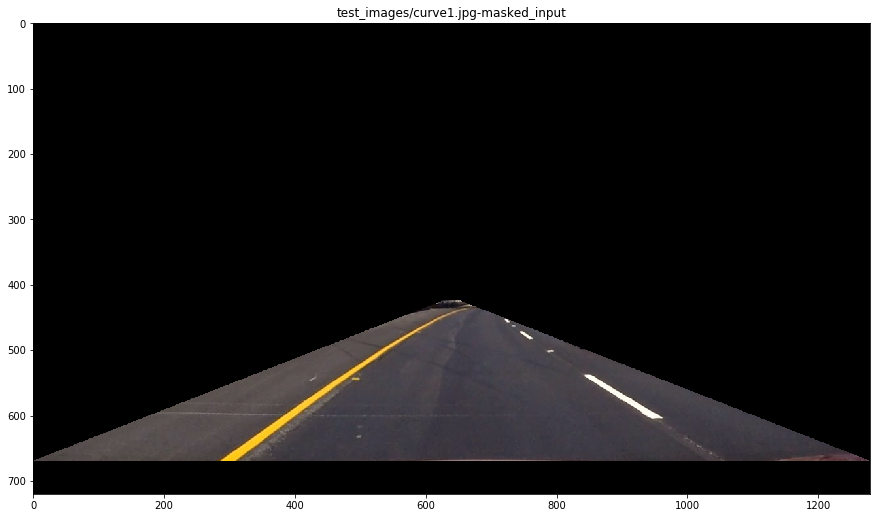

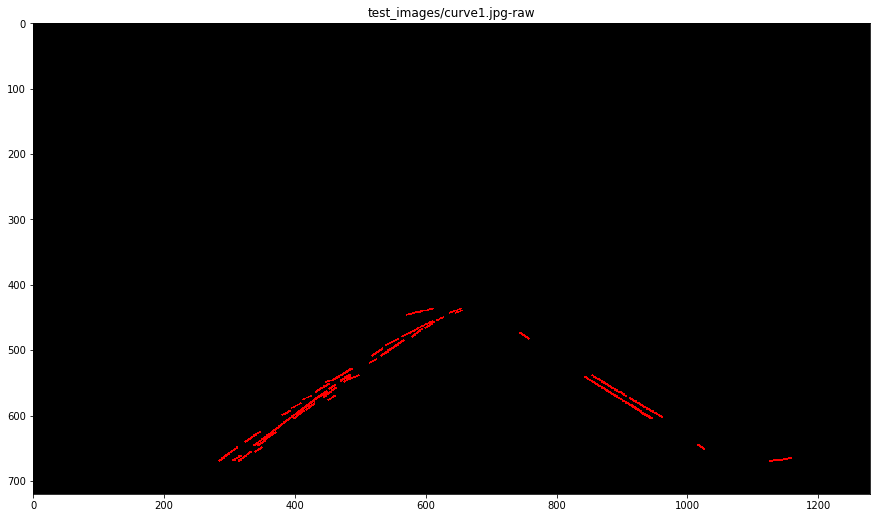

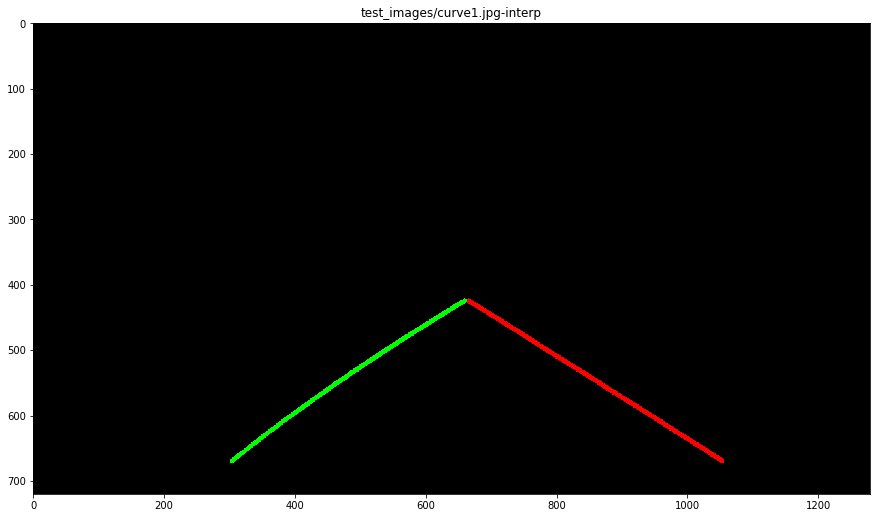

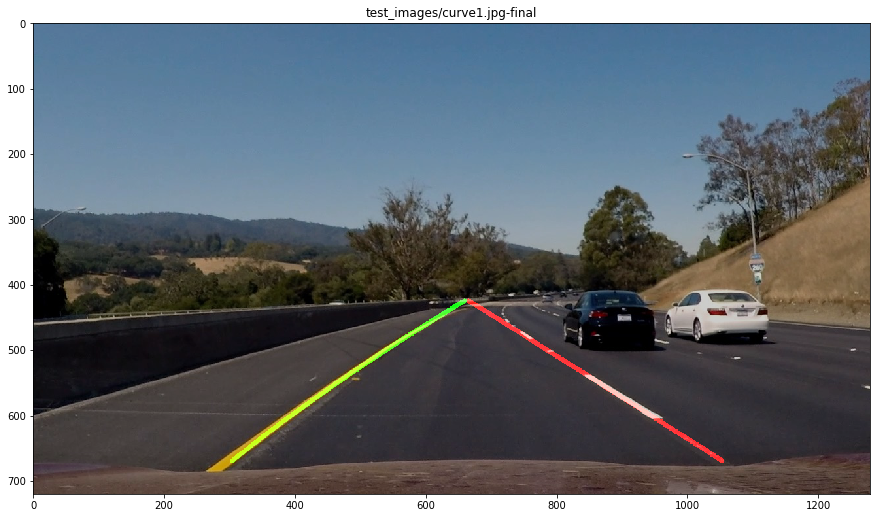

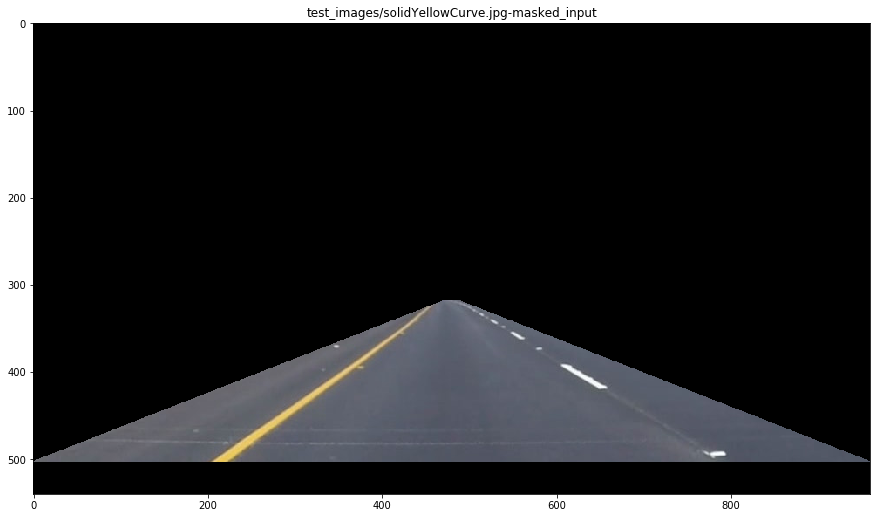

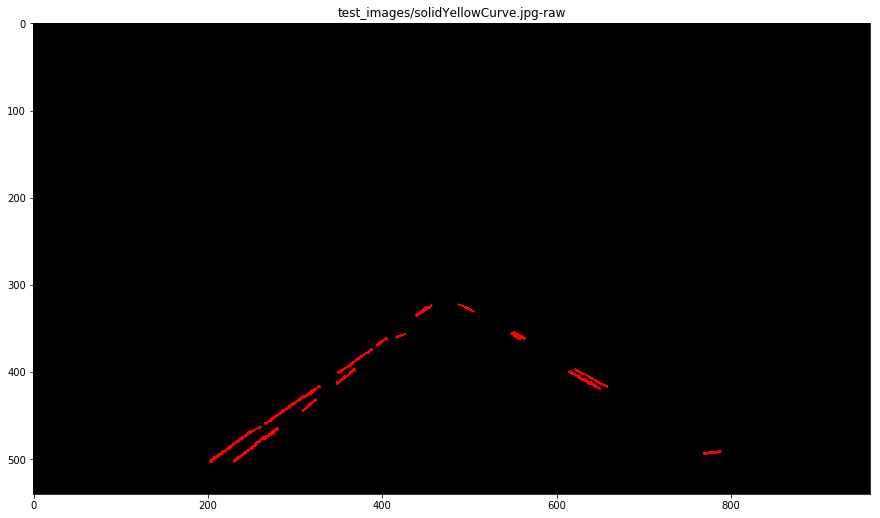

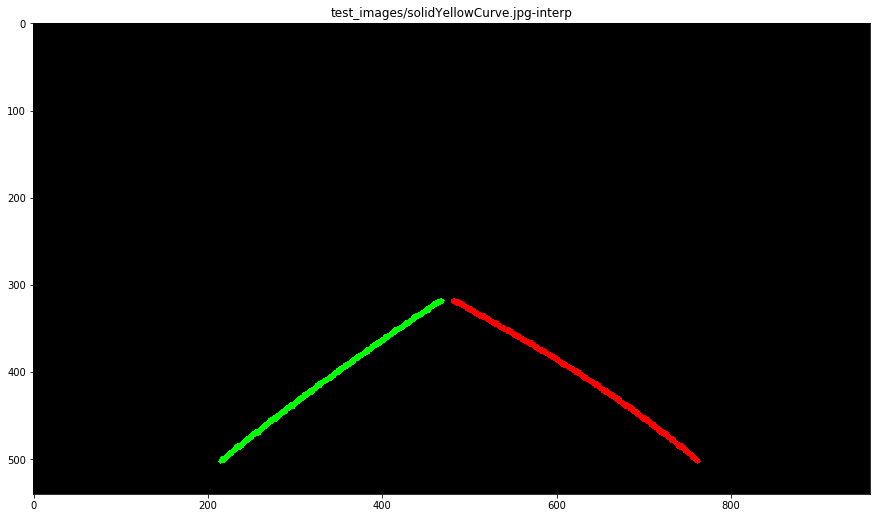

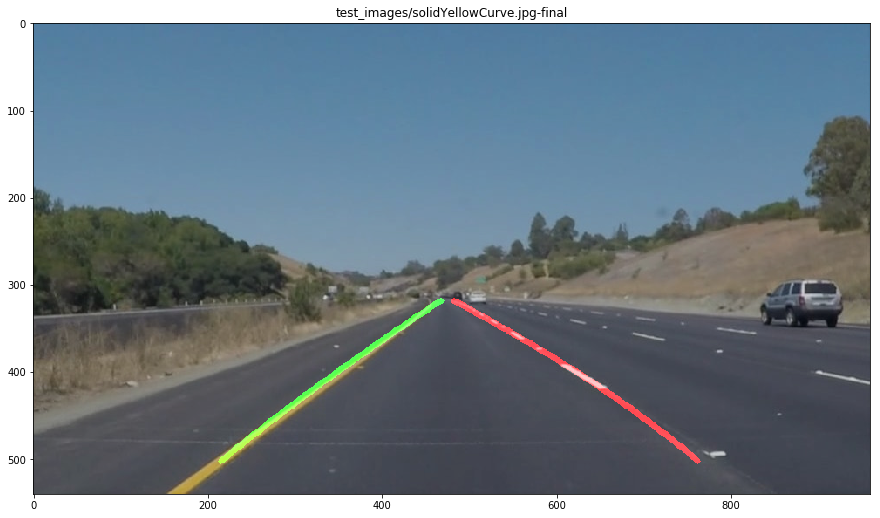

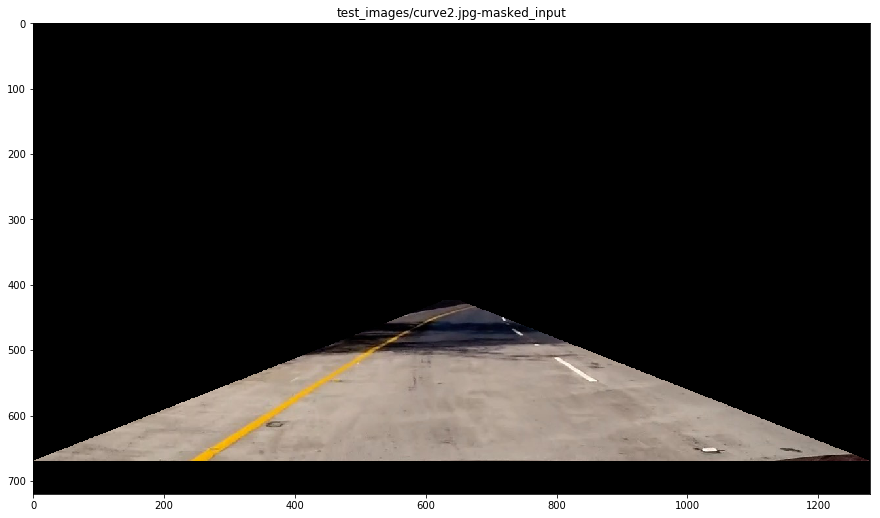

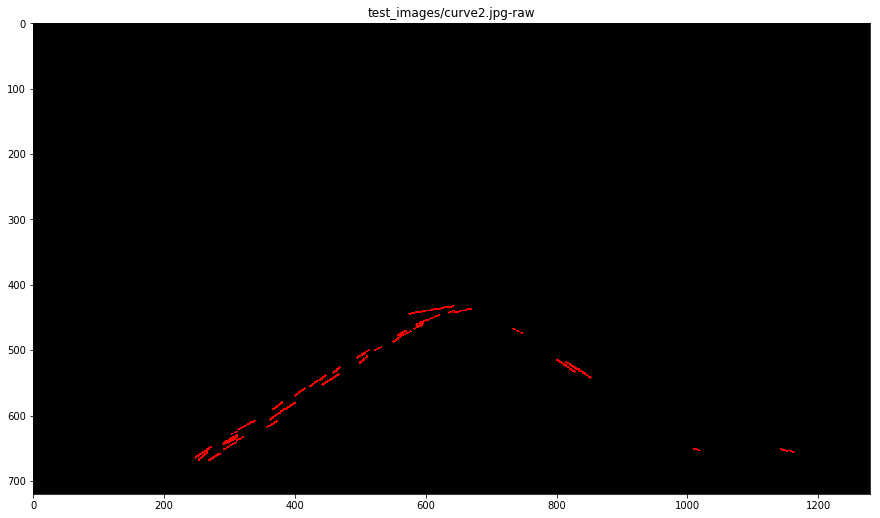

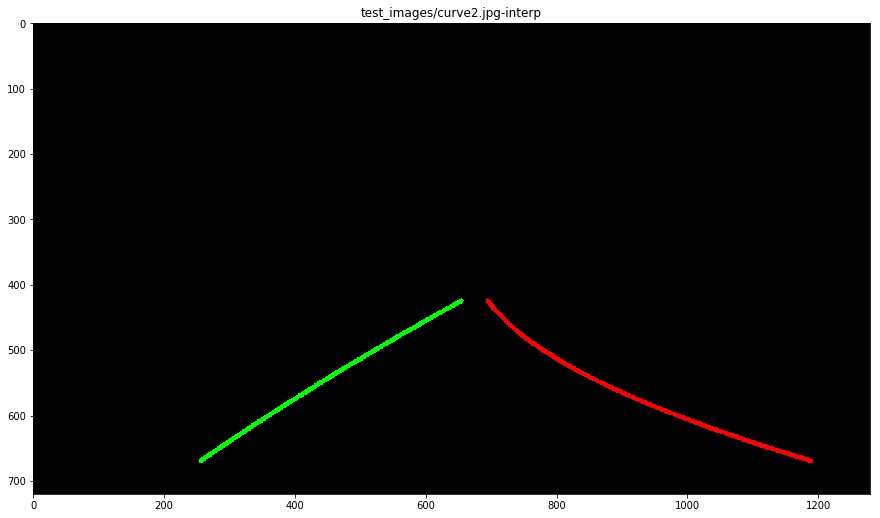

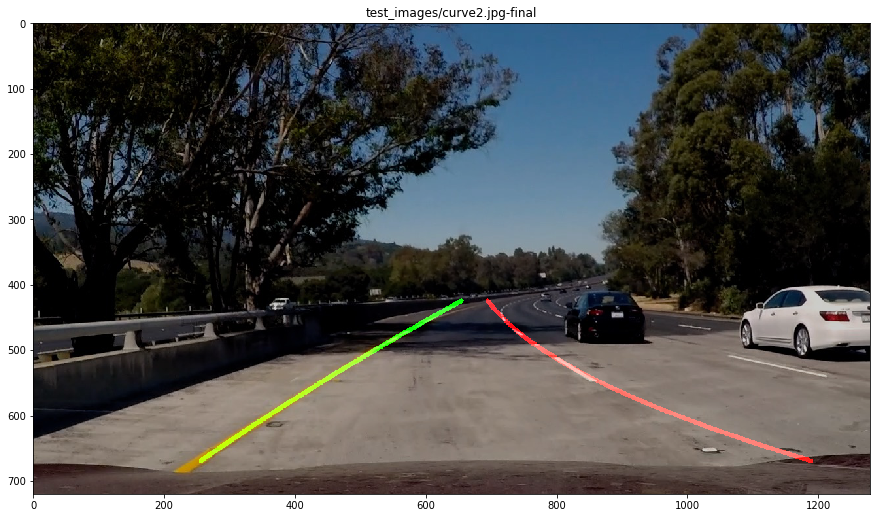

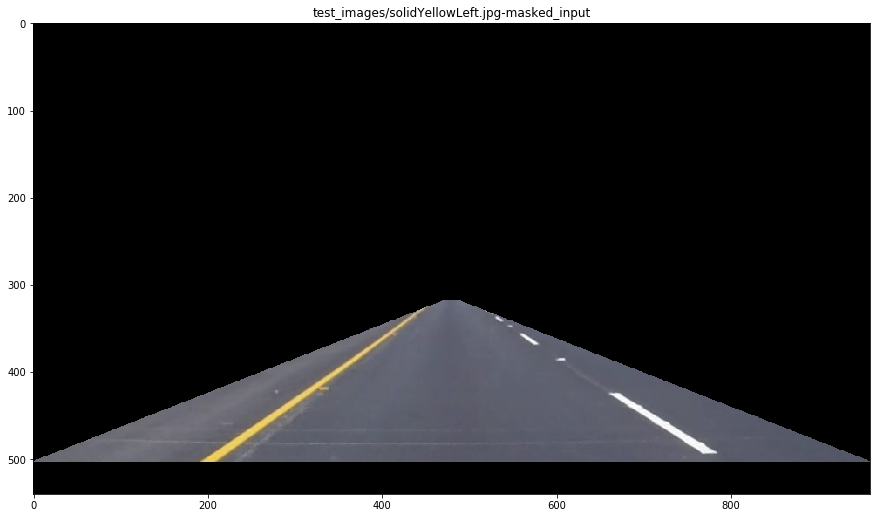

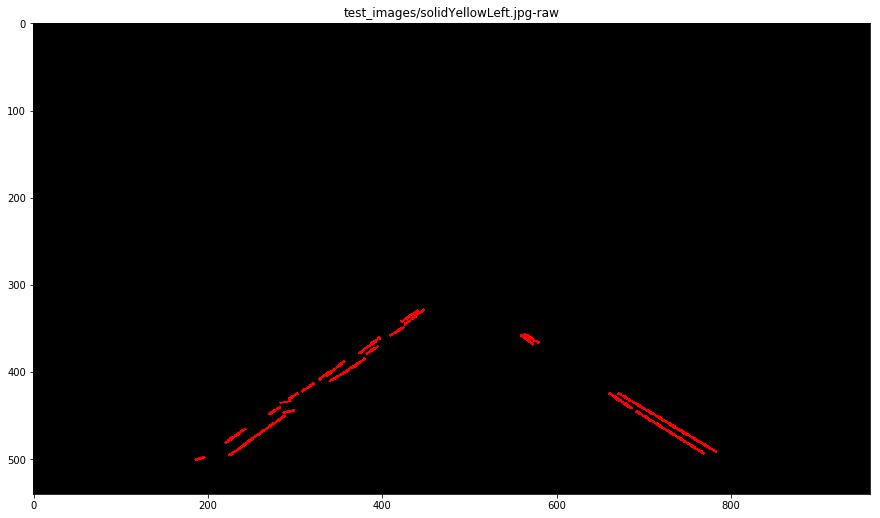

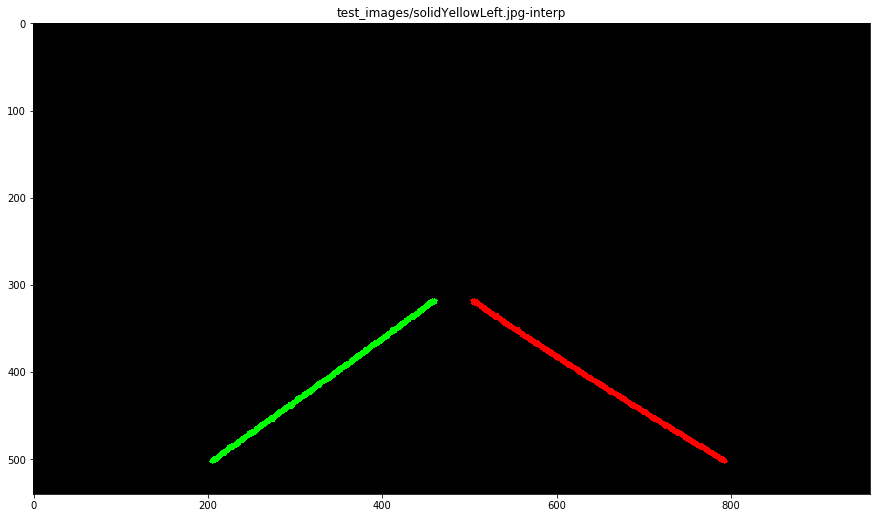

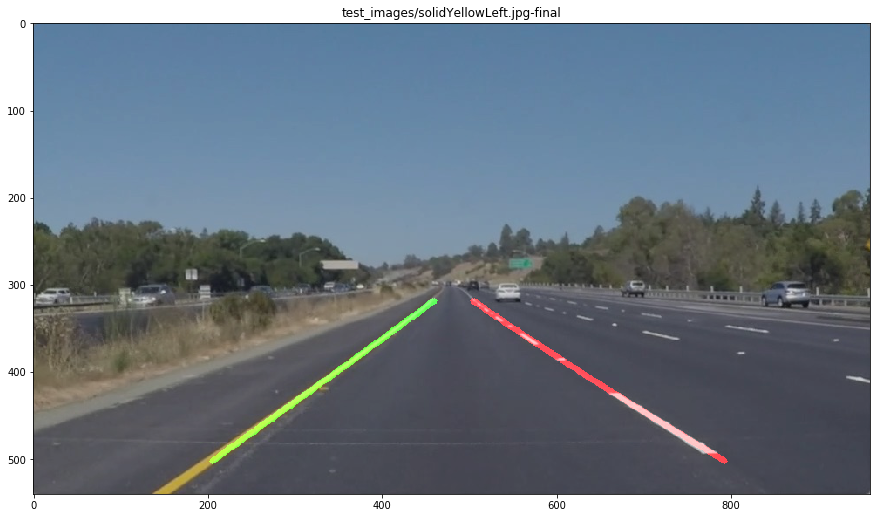

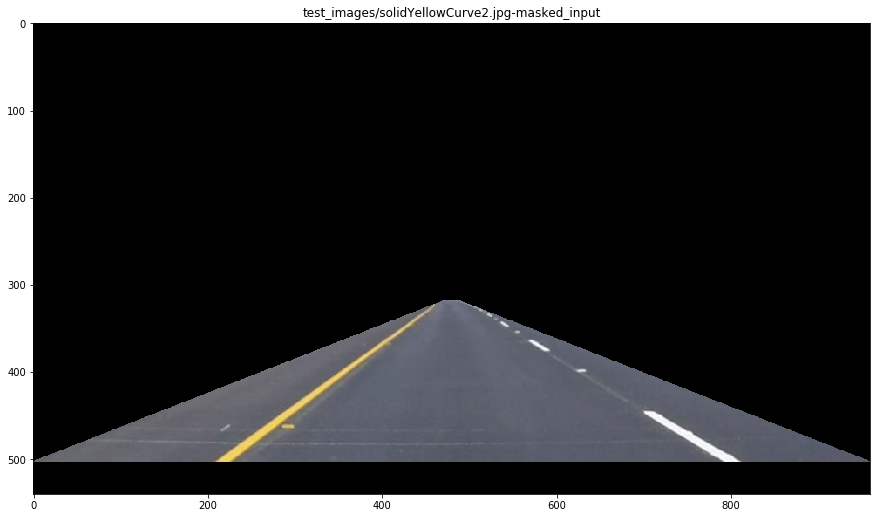

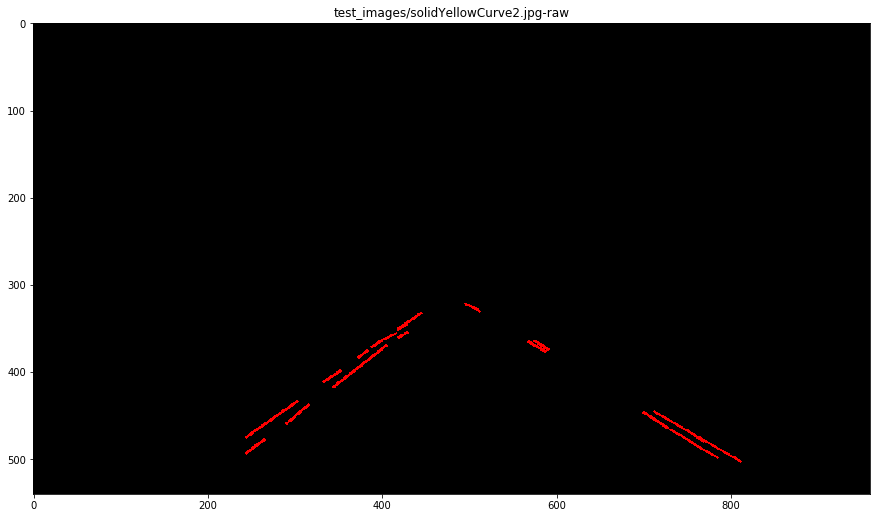

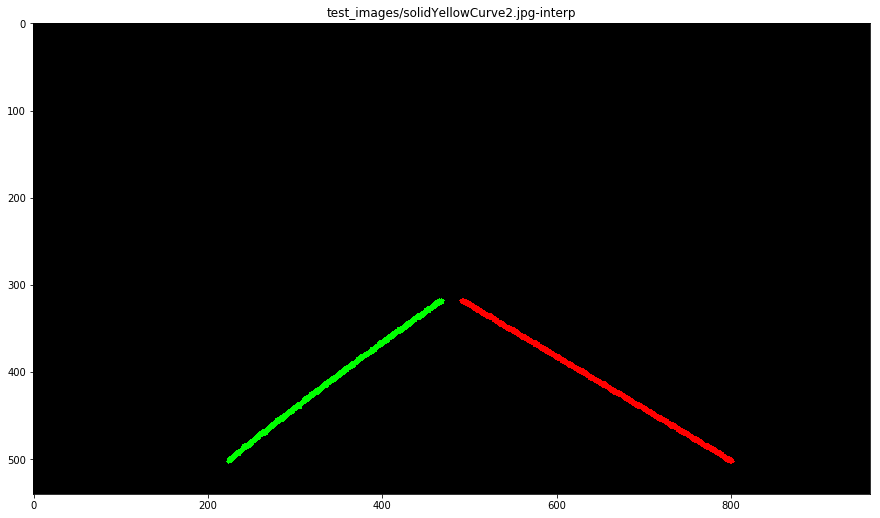

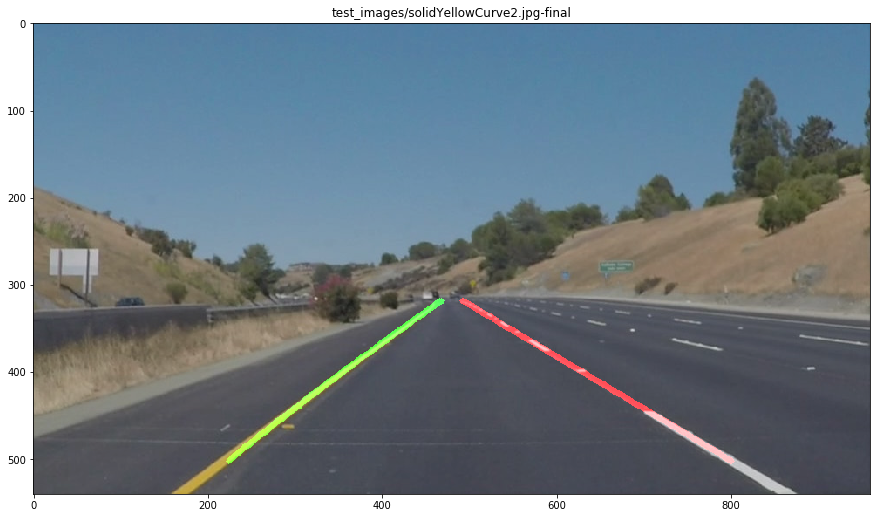

In [23]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def calc_region_vertices(img, y_min_percent, y_max_percent, x1_percent, x2_percent):
    y_size = img.shape[0]
    x_size = img.shape[1]
    
    x_pixels_per_cent = x_size / 100
    y_pixels_per_cent = y_size / 100
    
    ri_bl = (0, y_pixels_per_cent * y_max_percent)
    ri_apex1 = (x_pixels_per_cent * x1_percent, y_pixels_per_cent * y_min_percent)
    ri_apex2 = (x_pixels_per_cent * x2_percent, y_pixels_per_cent * y_min_percent)
    ri_br = (x_size, y_pixels_per_cent * y_max_percent)
    return np.array([[ri_bl, ri_apex1, ri_apex2, ri_br]], dtype=np.int32)

def lane_detection_pipeline(img):
    
    # Canny params.
    canny_threshold_low = 60
    canny_threshold_high = 180

    # Gaussian blur params
    gaussian_blur_kernel_size = 5

    #Region of interest params
    y_min_percent = 59
    y_max_percent = 93
    x1_percent = 49
    x2_percent = 51
    vertices = calc_region_vertices(img, y_min_percent, y_max_percent, x1_percent, x2_percent)

    ## Hough params
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments

    min_y = vertices[0][0][1];
    max_y = vertices[0][1][1];

    debug_imgs = []
    
    masked_input = region_of_interest(img, vertices)
    debug_imgs.append(("masked_input", masked_input))
    
    #1 Gray
    gray = grayscale(img)
    # debug_imgs.append(("gray", gray))
    
    #2 Blur - remove noise
    blur = gaussian_blur(gray, gaussian_blur_kernel_size)
    # debug_imgs.append(("blur", blur))
    #3 Edge detection
    edges = canny(blur, canny_threshold_low, canny_threshold_high)
    # debug_imgs.append(("edges", edges))
    #4 Mask region of interest
    masked = region_of_interest(edges, vertices)
    # debug_imgs.append(("masked", masked))
    #5 Extract hough linesds
    lines = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap, min_y, max_y)
    if lines is None: return img, debug_imgs
    
    # prepare different images
    shape = (img.shape[0], img.shape[1], 3)
    
    raw_lines_img = draw_lines_raw(shape, lines)
    debug_imgs.append(("raw", raw_lines_img))
    
    ave_lines_img = draw_lines_averaged(shape, lines, min_y, max_y, [0, 190, 0])
    # debug_imgs.append(("average", ave_lines_img))
    
    interpolated_lines_img = draw_lines_interpolated(shape, lines, min_y, max_y)
    debug_imgs.append(("interp", interpolated_lines_img))
 
    #6 Overlay - pick one to put into the final img
    final = weighted_img(interpolated_lines_img, img)
    debug_imgs.append(("final", final))
    return final, debug_imgs

def test_pipeline() :
    idx = 0
    for input_image in test_images :
        image = mpimg.imread(input_image)
        final, pipeline_images = lane_detection_pipeline(image) 

        for img_name, output_img in pipeline_images:
            plt.figure(idx, figsize=(15, 18))
            plt.title("{}-{}".format(input_image, img_name))
            plot_number = idx
            plt.imshow(output_img, cmap='Greys_r')
            idx += 1
    plt.show()

    
test_pipeline()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(img):
    final, debug_imgs = lane_detection_pipeline(img)
    return final

Let's try the one with the solid white lane on the right first ...

In [32]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:18<00:00, 11.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.92 s, sys: 243 ms, total: 6.16 s
Wall time: 20.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [34]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:01<00:00, 11.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 18.4 s, sys: 698 ms, total: 19.1 s
Wall time: 1min 3s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:46<00:00,  5.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.5 s, sys: 434 ms, total: 13 s
Wall time: 50.7 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))